<a href="https://colab.research.google.com/github/AROY13-PRAETORIAN/Neural_Style_Transfer/blob/main/STYLE_TRANSFER_AROY13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#@title
import os
img_dir = '/tmp/nst'
if not os.path.exists(img_dir):
    os.makedirs(img_dir)
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/d/d7/Green_Sea_Turtle_grazing_seagrass.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/b/b4/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/6/68/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg

In [3]:
#@title
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time
import functools

In [4]:
#@title
%tensorflow_version 1.x
import tensorflow as tf

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

TensorFlow 1.x selected.


In [5]:
#@title
tf.enable_eager_execution()
print("Eager execution: {}".format(tf.executing_eagerly()))

Eager execution: True


In [6]:
#@title
def load_img(path_to_img):
  max_dim = 512
  img = Image.open(path_to_img)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  
  img = kp_image.img_to_array(img)
  
  # We need to broadcast the image array such that it has a batch dimension 
  img = np.expand_dims(img, axis=0)
  return img

In [7]:
#@title
def imshow(img, title=None):
  # Remove the batch dimension
  out = np.squeeze(img, axis=0)
  # Normalize for display 
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  plt.imshow(out)

In [8]:
#@title
def load_and_process_img(path_to_img):
  img = load_img(path_to_img)
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return img

In [9]:
#@title
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [10]:
#@title
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [11]:
#@title
def get_model():
  # Load our model. We load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  # Get output layers corresponding to style and content layers 
  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  content_outputs = [vgg.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs
  # Build model 
  return models.Model(vgg.input, model_outputs)

In [12]:
#@title
def get_content_loss(base_content, target):
  return tf.reduce_mean(tf.square(base_content - target))

In [13]:
#@title
def gram_matrix(input_tensor):
  # We make the image channels first 
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
  # height, width, num filters of each layer
  # We scale the loss at a given layer by the size of the feature map and the number of filters
  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)
  
  return tf.reduce_mean(tf.square(gram_style - gram_target))# / (4. * (channels ** 2) * (width * height) ** 2)

In [14]:
#@title
def get_feature_representations(model, content_path, style_path):
  # Load our images in 
  content_image = load_and_process_img(content_path)
  style_image = load_and_process_img(style_path)
  
  # batch compute content and style features
  style_outputs = model(style_image)
  content_outputs = model(content_image)
  
  
  # Get the style and content feature representations from our model  
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features

In [15]:
#@title
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  style_weight, content_weight = loss_weights
  
  # Feed our init image through our model. This will give us the content and 
  # style representations at our desired layers. Since we're using eager
  # our model is callable just like any other function!
  model_outputs = model(init_image)
  
  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]
  
  style_score = 0
  content_score = 0

  # Accumulate style losses from all layers
  # Here, we equally weight each contribution of each loss layer
  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
  # Accumulate content losses from all layers 
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
  style_score *= style_weight
  content_score *= content_weight

  # Get total loss
  loss = style_score + content_score 
  return loss, style_score, content_score

In [16]:
#@title
def compute_grads(cfg):
  with tf.GradientTape() as tape: 
    all_loss = compute_loss(**cfg)
  # Compute gradients wrt input image
  total_loss = all_loss[0]
  return tape.gradient(total_loss, cfg['init_image']), all_loss

In [17]:
#@title
import IPython.display

def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=1000,
                       content_weight=1e3, 
                       style_weight=1e-2): 
  # We don't need to (or want to) train any layers of our model, so we set their
  # trainable to false. 
  model = get_model() 
  for layer in model.layers:
    layer.trainable = False
  
  # Get the style and content feature representations (from our specified intermediate layers) 
  style_features, content_features = get_feature_representations(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
  # Set initial image
  init_image = load_and_process_img(content_path)
  init_image = tf.Variable(init_image, dtype=tf.float32)
  # Create our optimizer
  opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)

  # For displaying intermediate images 
  iter_count = 1
  
  # Store our best result
  best_loss, best_img = float('inf'), None
  
  # Create a nice config 
  loss_weights = (style_weight, content_weight)
  cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }
    
  # For displaying
  num_rows = 2
  num_cols = 5
  display_interval = num_iterations/(num_rows*num_cols)
  start_time = time.time()
  global_start = time.time()
  
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   
  
  imgs = []
  for i in range(num_iterations):
    grads, all_loss = compute_grads(cfg)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time() 
    
    if loss < best_loss:
      # Update best loss and best image from total loss. 
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

    if i % display_interval== 0:
      start_time = time.time()
      
      # Use the .numpy() method to get the concrete numpy array
      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      imgs.append(plot_img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))        
      print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
  print('Total time: {:.4f}s'.format(time.time() - global_start))
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  for i,img in enumerate(imgs):
      plt.subplot(num_rows,num_cols,i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])
      
  return best_img, best_loss 

In [18]:
#@title
def show_results(best_img,show_large_final=True):
  if show_large_final: 
    plt.figure(figsize=(10, 10))
    plt.imshow(best_img)
    plt.axis('off')
    plt.savefig("abc.png", bbox_inches=0)
    plt.show()

In [19]:
#@title
import os
from google.colab import files
import shutil
neural_style_transfer_path = '/content/drive/MyDrive/style_transfer_MAIN'
base_layer = '/content/drive/MyDrive/style_transfer_MAIN/base'
style_layer = '/content/drive/MyDrive/style_transfer_MAIN/style'
output = '/content/drive/MyDrive/style_transfer_MAIN/output'
if not os.path.exists(neural_style_transfer_path):
  os.mkdir(neural_style_transfer_path)
if not os.path.exists(base_layer):
  os.mkdir(base_layer)
if not os.path.exists(style_layer):
  os.mkdir(style_layer)
if not os.path.exists(output):
  os.mkdir(output)

# **UPLOAD IMAGES TO WHICH YOU WANT TO APPLY YOUR STYLE LAYER**

In [20]:
#@title
base_upload = files.upload()
for filename in base_upload.keys():
  dst_path = os.path.join(base_layer, filename)
  shutil.move(filename, dst_path)

Saving _65221495_dal4iy2t.jpg to _65221495_dal4iy2t.jpg


# **UPLOAD STYLE LAYERS**

In [21]:
#@title
style_upload = files.upload()
for filename in style_upload.keys():
  dst_path = os.path.join(style_layer, filename)
  shutil.move(filename, dst_path)

Saving style1.jpg to style1.jpg


In [22]:
#@title
import glob
%cd {base_layer}
base_lst_imgs = [i for i in glob.glob("*.jpg")]
list_of_images=[]
for i in base_lst_imgs:
  abc = base_layer+"/" + i 
  list_of_images.append(abc)
print(list_of_images)

/content/drive/MyDrive/style_transfer_MAIN/base
['/content/drive/MyDrive/style_transfer_MAIN/base/_65221495_dal4iy2t.jpg']


In [23]:
#@title
%cd {style_layer}
lst_imgs = [i for i in glob.glob("*.jpg")]
list_of_styles=[]
for i in lst_imgs:
  abc = style_layer+"/" + i 
  list_of_styles.append(abc)
print(list_of_styles)

/content/drive/MyDrive/style_transfer_MAIN/style
['/content/drive/MyDrive/style_transfer_MAIN/style/style1.jpg']


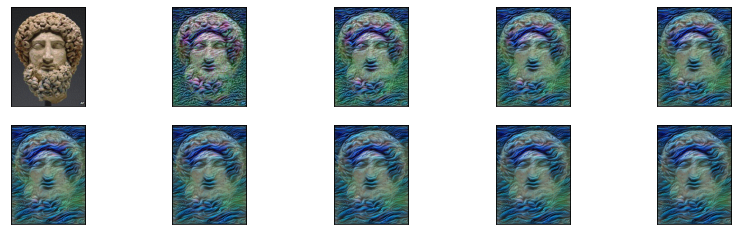

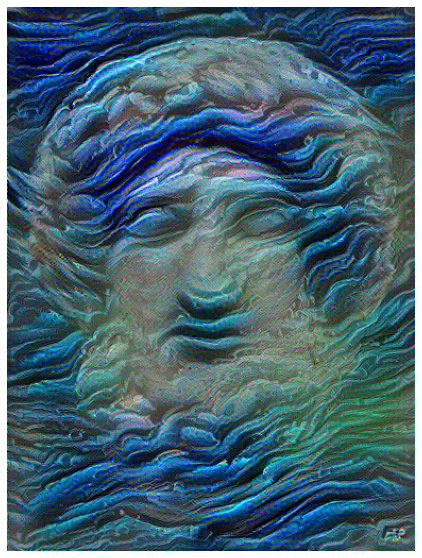

In [24]:
#@title
%cd {output}
show_large_finals=True
from google.colab import files
for i in range(len(list_of_images)):
  image = list_of_images[i]
  for a in range(len(list_of_styles)):
    best_starry_night, best_loss = run_style_transfer(image,list_of_styles[a])
    if show_large_finals: 
        plt.figure(figsize=(10, 10))
        plt.imshow(best_starry_night)
        plt.axis('off')
        plt.savefig(str(i)+"_"+str(a)+"_image.png", bbox_inches=0)

# **DOWNLOAD ALL YOUR STYLED IMAGES**

In [ ]:
#@title
%cd {output}
zip_filename = "styled_image.zip"
if os.path.exists(zip_filename):
  os.remove(zip_filename)
!zip -r {zip_filename} {output_path}
files.download("styled_image.zip")

# **CLEAR GPU MEMORY**

In [35]:
#@title
print("Time                     GPU        Used      Total")
!nvidia-smi --query-gpu=timestamp,name,memory.used,memory.free --format=csv,noheader
import gc
import torch
gc.collect()
torch.cuda.empty_cache()
!nvidia-smi --query-gpu=timestamp,name,memory.used,memory.free --format=csv,noheader

Time                     GPU        Used      Total
2021/10/11 09:20:21.863, Tesla P100-PCIE-16GB, 7193 MiB, 9087 MiB
2021/10/11 09:20:22.117, Tesla P100-PCIE-16GB, 7193 MiB, 9087 MiB


# **UPSCALER**

In [26]:
#@title

%cd {neural_style_transfer_path}
!git clone https://github.com/xinntao/Real-ESRGAN.git
%cd Real-ESRGAN
!pip install basicsr
!pip install facexlib
!pip install gfpgan
!pip install -r requirements.txt
!python setup.py develop
!wget https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth -P experiments/pretrained_models

/content/drive/MyDrive/style_transfer_MAIN
fatal: destination path 'Real-ESRGAN' already exists and is not an empty directory.
/content/drive/MyDrive/style_transfer_MAIN/Real-ESRGAN
     |████████████████████████████████| 149 kB 15.7 MB/s 
     |████████████████████████████████| 5.8 MB 68.4 MB/s 
     |████████████████████████████████| 185 kB 74.3 MB/s 
  Created wheel for basicsr: filename=basicsr-1.3.4.4-py3-none-any.whl size=185576 sha256=b04f873c1f8ff005abef4072cd0ca4259de9747a54c09495b13fb1aa7e638365
  Stored in directory: /root/.cache/pip/wheels/ae/4c/74/8658a322336367833c17a3777611cb59a6a5dcfb904afc64cb
Successfully built basicsr


     |████████████████████████████████| 1.1 MB 12.8 MB/s 
     |████████████████████████████████| 177 kB 65.1 MB/s 
  Created wheel for facexlib: filename=facexlib-0.2.1.0-py3-none-any.whl size=57093 sha256=5cb81aff569aa47530e46669b1779932cdda2e306833d3d98c7030f36293e9ed
  Stored in directory: /root/.cache/pip/wheels/e3/33/8d/70d77abe7eca95c8b0f32f12867234c45c1089db9db7102d03
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110474 sha256=8536384cfa50c0942556d44f85805d38b17058d150a048812215895d50ab6388
  Stored in directory: /root/.cache/pip/wheels/ce/e0/ee/a2b3c5caab3418c1ccd8c4de573d4cbe13315d7e8b0a55fbc2
Successfully built facexlib filterpy
  Created wheel for gfpgan: filename=gfpgan-0.2.1-py3-none-any.whl size=35469 sha256=b7906e4e8052588385ccf1913253ddaa536833aa87e16b64a98bbd8da30d5113
  Stored in directory: /root/.cache/pip/wheels/77/3e/9d/c3334b221f11764db98224dc386fb04d9de005bd7649e37ba0
Successfully built gfpgan
running develop
running egg_info
writin

In [31]:
#@title

import os
from google.colab import files
import shutil

upload_folder = 'upload'
result_folder = 'results'

if os.path.isdir(upload_folder):
    shutil.rmtree(upload_folder)
if os.path.isdir(result_folder):
    shutil.rmtree(result_folder)
os.mkdir(upload_folder)
os.mkdir(result_folder)


In [32]:
#@title

%cd {output}
final_output = [i for i in glob.glob("*.png")]
list_of_styled_images=[]
for i in final_output:
  abc = output+"/" + i 
  list_of_styled_images.append(abc)
print(list_of_styled_images)
move_for_upscaling = neural_style_transfer_path+"/"+"Real-ESRGAN/upload"
for i in list_of_styled_images:
  shutil.move(i, move_for_upscaling)


/content/drive/MyDrive/style_transfer_MAIN/output
['/content/drive/MyDrive/style_transfer_MAIN/output/0_0_image.png']


In [36]:
#@title

%cd {neural_style_transfer_path}
%cd Real-ESRGAN
!python inference_realesrgan.py --model_path experiments/pretrained_models/RealESRGAN_x4plus.pth --input upload --netscale 4 --outscale 3.5 --half --face_enhance


/content/drive/MyDrive/style_transfer_MAIN
/content/drive/MyDrive/style_transfer_MAIN/Real-ESRGAN
Testing 0 0_0_image
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [37]:
#@title

# Download the results
zip_filename = 'upscaled_images.zip'
if os.path.exists(zip_filename):
  os.remove(zip_filename)
os.system(f"zip -r -j {zip_filename} results/*")
files.download(zip_filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>